# TF-MoDISco on the Nanog GkmExplain Scores

This notebook demonstrates running TF-MoDISco on importance scores obtained from GkmExplain on Nanog ChIP-seq data in H1ESCs. See https://github.com/kundajelab/gkmexplain/blob/master/lsgkmexplain_Nanog.ipynb for a notebook demonstrating how to produce the scores.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

TF-MoDISco is using the TensorFlow backend.
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_impscores.txt.gz -O gkmexplain_positives_impscores.txt.gz
!gunzip gkmexplain_positives_impscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/c8ebc38/modisco/gkmexplain_scores/gkmexplain_dnshuff_impscores.txt.gz -O gkmexplain_dnshuff_impscores.txt.gz
!gunzip gkmexplain_dnshuff_impscores.txt.gz

--2020-04-18 18:47:02--  https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: 'positives_test.fa.gz'

100%[======================================>] 75,038      --.-K/s   in 0.04s   

2020-04-18 18:47:02 (1.88 MB/s) - 'positives_test.fa.gz' saved [75038/75038]

--2020-04-18 18:47:02--  https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_impscores.txt.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1000384 (977K) [application/octet-stream]
Saving to: 'gkmexplain_positives_impscores.txt.gz'

100%[=========

### Read in the one-hot encoded sequences and scores

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("positives_test.fa"))
              if i%2==1]
#filter out any sequences that contain 'N's
onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                         for x in fasta_seqs if ('N' not in x)]
print("Num onehot sequences:",len(onehot_data))

#read in the importance scores and hypothetical importance scores
#filter out any sequences that contain 'N's
hyp_impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_hypimpscores.txt")
],fasta_seqs) if 'N' not in w[1]]

impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_impscores.txt")
],fasta_seqs) if 'N' not in w[1]]

#Perform a sanity check to make sure that the importance score are the same as the
# hypothetical scores multiplied elementwise with the one-hot encoding; for this
# reason, it is not technically necessary to compute the importance scores if the
# hypothetical scores are also computed
assert (np.max([np.max(np.abs(z*y - x)) for x,y,z in zip(impscores,onehot_data,hyp_impscores)]))==0

#Read in scores on the dinucleotide-shuffled sequences, taking
# the sum across ACGT at each position, to get an empirical null distribution
# of per-position importance scores
nulldist_perposimp = [
    np.array( [sum([float(z) for z in y.split(",")]) for
                y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_dnshuff_impscores.txt")]

Num onehot sequences: 960


NOTE: in the original GkmExplain paper, a normalization of the importance scores and hypothetical importance scores was proposed, as this was empirically observed to improve the signal-to-noise ratio. For simplicity, we are not applying that normalization here. For details on that normalization, see the Nanog TF-MoDISco notebook in the GkmExplain repo: https://github.com/kundajelab/gkmexplain/blob/master/lsgkmexplain_Nanog.ipynb

Sanity check the scores by plotting

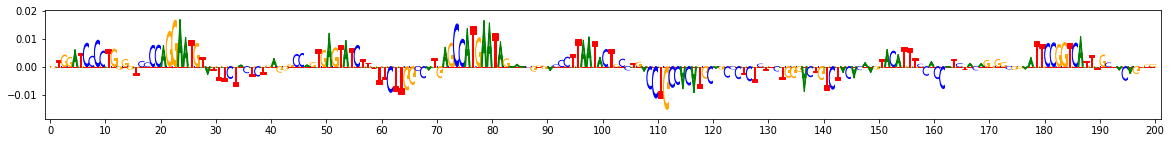

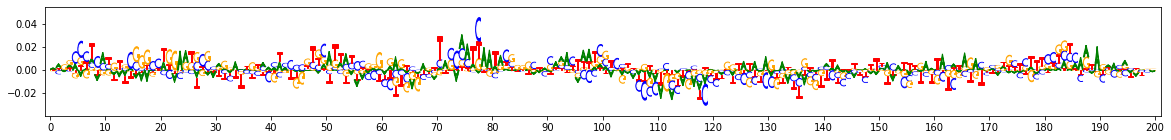

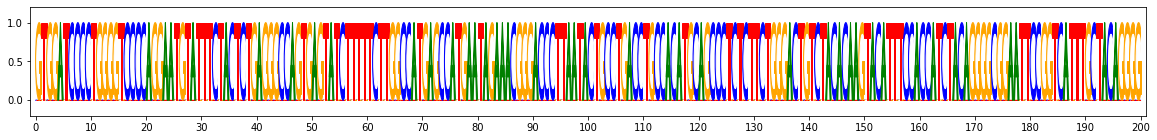

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- An empirical null distribution is supplied for per-position importance scores using the argument `null_per_pos_scores`
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, importance scores are first smoothed with a window of size `sliding_window_size` (default value of 21 at the time of writing), and the FDR for scores in sliding windows is estimated using the supplied empirical null distribution. This is used to set a threshold on sliding windows that can go on to form seqlets. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.
- (new in version 0.5.6.0) MEME is run on the seqlets to find 10 motifs, and the significant motifs are used to initialize TF-MoDISco's Leiden clustering. This initialization is handled by the initclusterer_factory argument.
- The code below uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine when run on computing servers, but not when run on my 6-year-old personal laptop.


MEMORY 0.314507264
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold


TF-MoDISco is using the TensorFlow backend.


Thresholds from null dist were -0.32632443699999997  and  0.26635030000000004
Final raw thresholds are -0.32632443699999997  and  0.26635030000000004
Final transformed thresholds are -0.9486284722222222  and  0.9078125


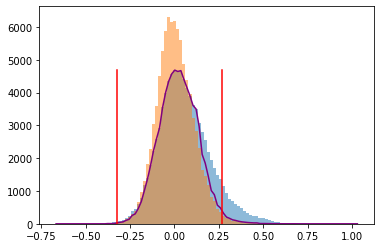

Got 974 coords
After resolving overlaps, got 974 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9077125
MEMORY 0.324947968
974 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [936]
Idx to activities:  {0: '1'}
MEMORY 0.32495616
On metacluster 0
Metacluster size 936
Relevant tasks:  ('task0',)
Relevant signs:  (1,)

TfModiscoSeqletsToPatternsFactory: seed=1234
Running MEME
Command: meme meme_out/metacluster0/inp_seqlets.fa -dna -mod anr -nmotifs 10 -minw 6 -maxw 50 -oc meme_out/metacluster0
Duration of MEME: 649.4617848396301 seconds
Skipping motif ARAGCCATYAR as e-value 4.0 does not meet threshold of 0.05
Skipping motif MCTGGGGWGATTAG as e-value 140.0 does not meet threshold of 0.05
Skipping motif SRGGSWGCHSATTVMARGCCYTYTDTSMT as e-value 840.0 does not meet threshold of 0.05
Of 936 seqlets, cluster assignments are: Counter({0: 273, 1: 186, 2: 159, 3: 106, 5: 97, 6: 56, 4: 46, -1: 13})
Aggregating for cl

Using TensorFlow backend.


Finished embedding computation in 5.38 s
Starting affinity matrix computations
Normalization computed in 0.08 s
Cosine similarity mat computed in 0.12 s
Normalization computed in 0.07 s
Cosine similarity mat computed in 0.11 s
Finished affinity matrix computations in 0.24 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.614453248
Computed nearest neighbors in 0.55 s
MEMORY 0.624594944
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.624594944
Launching nearest neighbors affmat calculation job
MEMORY 0.639930368
Parallel runs completed
MEMORY 0.543039488
Job completed in: 17.88 s
MEMORY 0.543051776
Launching nearest neighbors affmat calculation job
MEMORY 0.542990336
Parallel runs completed
MEMORY 0.5433344
Job completed in: 19.22 s
MEMORY 0.550346752
(Round 1) Computed affinity matrix on nearest neighbors in 37.35 s
MEMORY 0.551391232
Filtered down to 881 of 936
(Round 1) Retained 881 rows out of 936 after filtering
MEMORY 0.551563264
(Round 1) Computi

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.6321871309066026


  2%|▏         | 1/50 [00:00<00:10,  4.56it/s]

Quality: 0.6340057666018197


 12%|█▏        | 6/50 [00:01<00:09,  4.45it/s]

Quality: 0.6344305698961371


 30%|███       | 15/50 [00:03<00:08,  4.32it/s]

Quality: 0.6347567718451053


 64%|██████▍   | 32/50 [00:07<00:04,  4.17it/s]

Quality: 0.6349501686553548


100%|██████████| 50/50 [00:11<00:00,  4.55it/s]

Got 11 clusters after round 1
Counts:
{2: 129, 8: 24, 4: 63, 0: 215, 3: 118, 7: 35, 6: 38, 1: 177, 10: 8, 9: 21, 5: 53}
MEMORY 0.523554816
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.523554816
Aggregating for cluster 0 with 215 seqlets
MEMORY 0.523554816


Trimmed 5 out of 215
Skipped 24 seqlets
Aggregating for cluster 1 with 177 seqlets
MEMORY 0.523554816
Trimmed 4 out of 177
Skipped 24 seqlets
Aggregating for cluster 2 with 129 seqlets
MEMORY 0.523554816
Trimmed 9 out of 129
Skipped 20 seqlets
Aggregating for cluster 3 with 118 seqlets
MEMORY 0.523554816
Trimmed 6 out of 118
Skipped 19 seqlets
Aggregating for cluster 4 with 63 seqlets
MEMORY 0.523554816
Trimmed 1 out of 63
Skipped 14 seqlets
Aggregating for cluster 5 with 53 seqlets
MEMORY 0.523554816
Trimmed 3 out of 53
Skipped 12 seqlets
Aggregating for cluster 6 with 38 seqlets
MEMORY 0.523554816
Trimmed 1 out of 38
Skipped 5 seqlets
Aggregating for cluster 7 with 35 seqlets
MEMORY 0.523554816
Trimmed 2 out of 35
Skipped 6 seqlets
Aggregating for cluster 8 with 24 seqlets
MEMORY 0.523554816
Trimmed 1 out of 24
Skipped 4 seqlets
Aggregating for cluster 9 with 21 seqlets
MEMORY 0.523554816
Trimmed 0 out of 21
Skipped 6 seqlets
Aggregating for cluster 10 with 8 seqlets
MEMORY 0.5235548

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.5947804710964784


  2%|▏         | 1/50 [00:00<00:07,  6.79it/s]

Quality: 0.5985943230387598


  6%|▌         | 3/50 [00:00<00:08,  5.70it/s]

Quality: 0.6006581105405199


 10%|█         | 5/50 [00:00<00:08,  5.22it/s]

Quality: 0.6011033552804447


100%|██████████| 50/50 [00:10<00:00,  4.95it/s]

Got 10 clusters after round 2
Counts:
{0: 182, 3: 104, 9: 3, 1: 116, 2: 112, 8: 4, 7: 11, 6: 28, 5: 65, 4: 90}
MEMORY 0.561176576
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.561176576
Aggregating for cluster 0 with 182 seqlets
MEMORY 0.561176576


Trimmed 9 out of 182
Aggregating for cluster 1 with 116 seqlets
MEMORY 0.561176576
Trimmed 13 out of 116
Aggregating for cluster 2 with 112 seqlets
MEMORY 0.561176576
Trimmed 19 out of 112
Aggregating for cluster 3 with 104 seqlets
MEMORY 0.561176576
Trimmed 24 out of 104
Skipped 7 seqlets
Removed 2 duplicate seqlets
Aggregating for cluster 4 with 90 seqlets
MEMORY 0.561176576
Trimmed 5 out of 90
Aggregating for cluster 5 with 65 seqlets
MEMORY 0.561176576
Trimmed 0 out of 65
Skipped 2 seqlets
Aggregating for cluster 6 with 28 seqlets
MEMORY 0.561176576
Trimmed 5 out of 28
Aggregating for cluster 7 with 11 seqlets
MEMORY 0.561176576
Trimmed 5 out of 11
Aggregating for cluster 8 with 4 seqlets
MEMORY 0.561176576
Trimmed 0 out of 4
Aggregating for cluster 9 with 3 seqlets
MEMORY 0.561176576
Trimmed 0 out of 3
Got 10 clusters
Splitting into subclusters...
MEMORY 0.561106944
Inspecting for spurious merging
Wrote graph to binary file in 0.0648491382598877 seconds
Running Louvain modularity 

In [6]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        meme_command="meme", base_outdir="meme_out",   
                        #max_num_seqlets_to_use specifies the maximum number of seqlets to use
                        # with MEME (this is to speed up MEME in the cases where the number of seqlets is
                        #  very large)
                        max_num_seqlets_to_use=10000,
                        nmotifs=10,
                        n_jobs=1),
                    use_louvain=False,
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    #trim_to_window_size=6,
                    #initial_flank_to_add=2,
                    #final_flank_to_add=5,
                    #kmer_len, num_gaps and num_mismatches are used to
                    # derive kmer embeddings for coarse-grained affinity
                    # matrix calculation. kmer_len=6, num_gaps=1
                    # and num_mismatches=0 means
                    # that kmer embeddings using 6-mers with 1 gap will be
                    # used.
                    kmer_len=6, num_gaps=1,
                    num_mismatches=0,
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [7]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


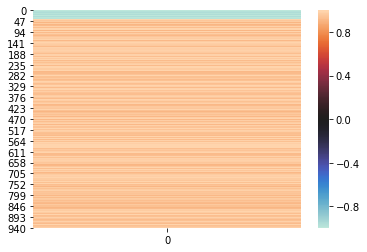

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 180
Hypothetical scores:


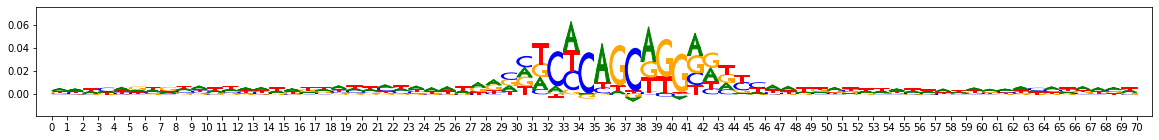

Actual importance scores:


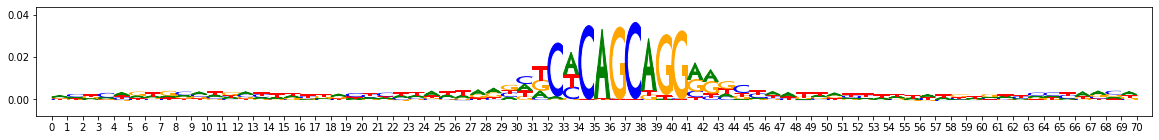

onehot, fwd and rev:


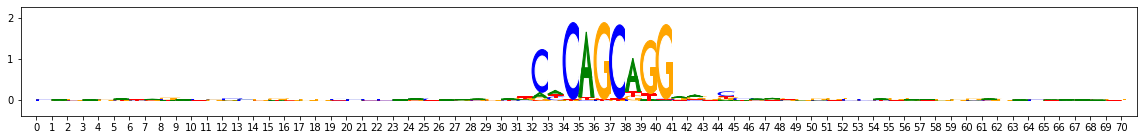

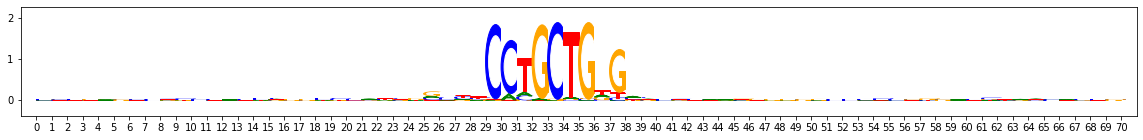

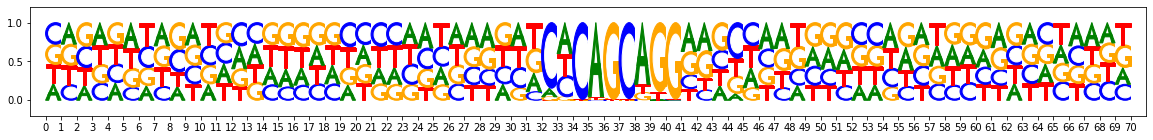

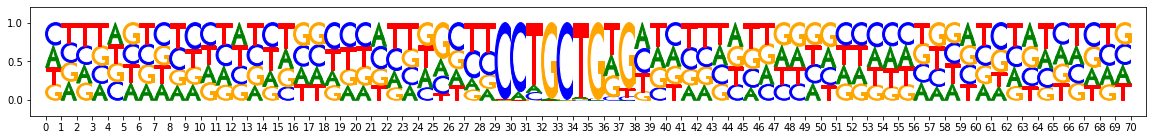

metacluster_0 pattern_1
total seqlets: 129
Hypothetical scores:


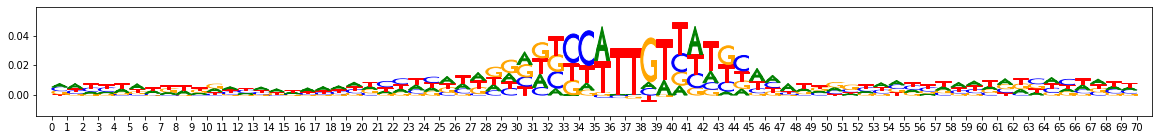

Actual importance scores:


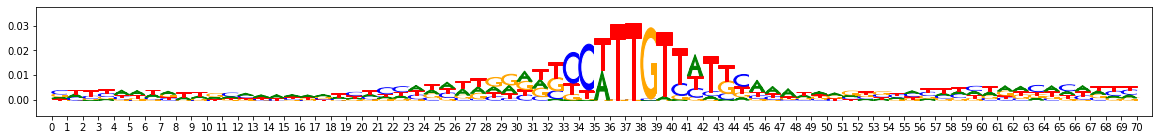

onehot, fwd and rev:


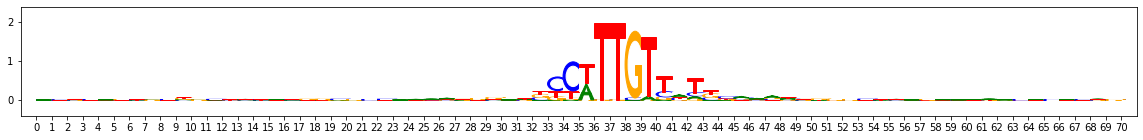

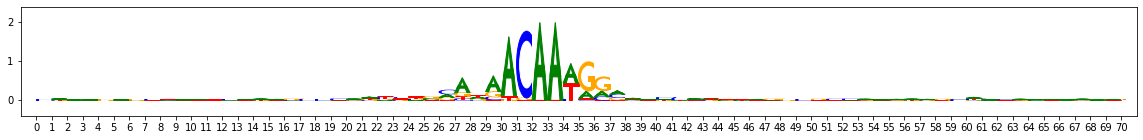

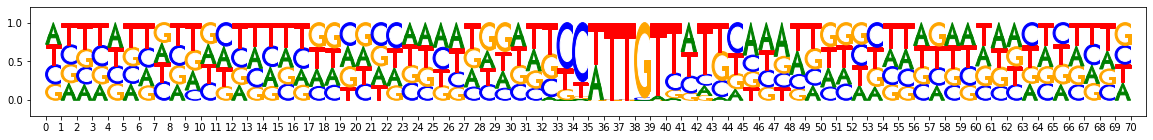

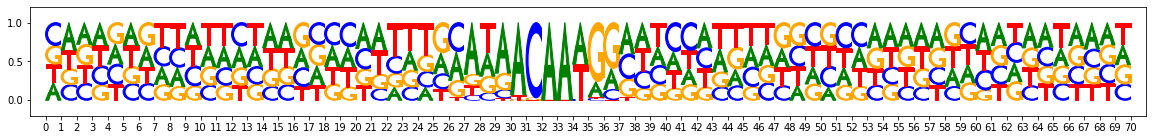

metacluster_0 pattern_2
total seqlets: 92
Hypothetical scores:


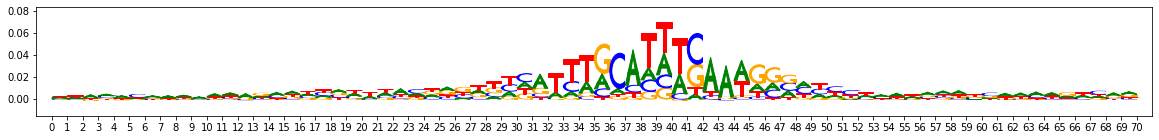

Actual importance scores:


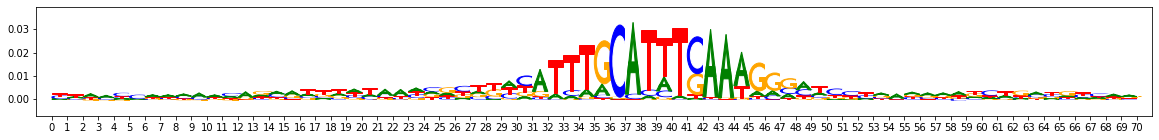

onehot, fwd and rev:


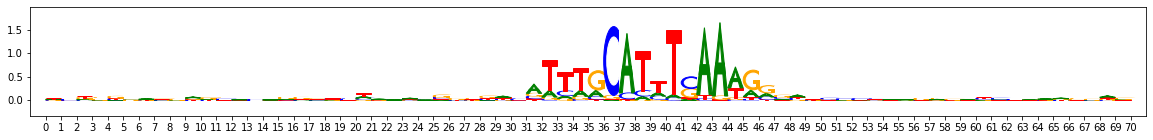

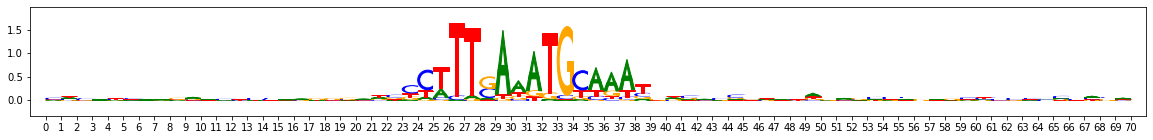

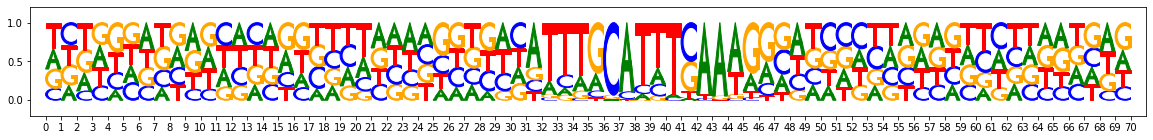

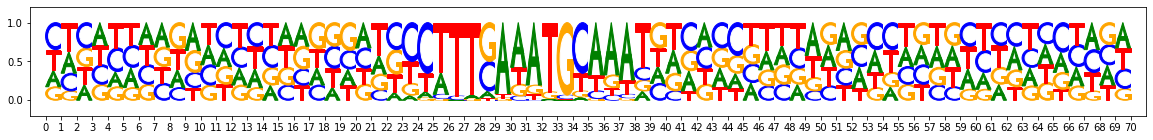

metacluster_0 pattern_3
total seqlets: 70
Hypothetical scores:


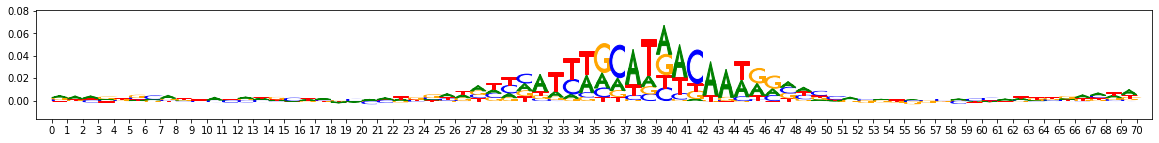

Actual importance scores:


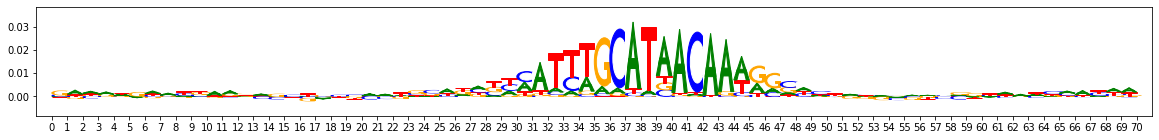

onehot, fwd and rev:


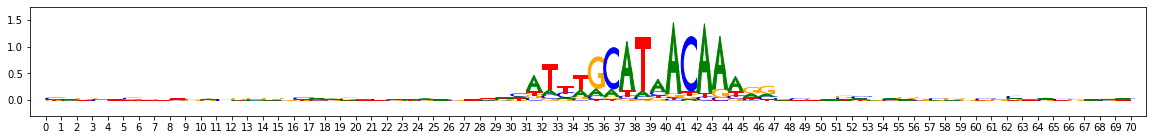

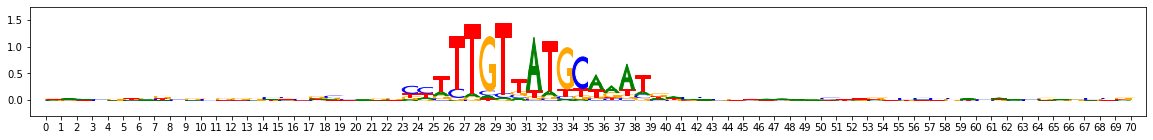

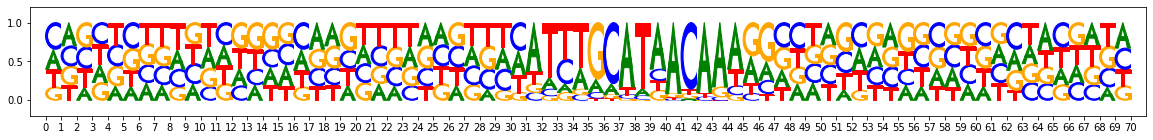

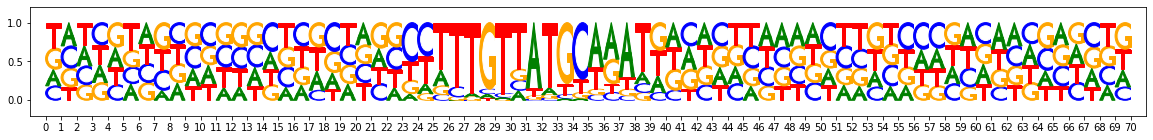

metacluster_0 pattern_4
total seqlets: 91
Hypothetical scores:


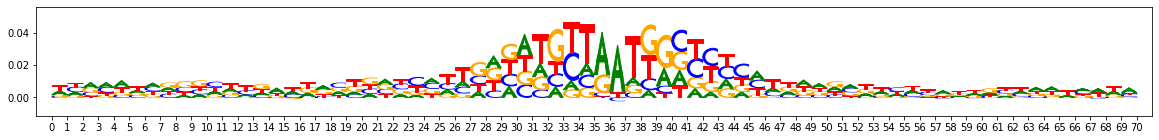

Actual importance scores:


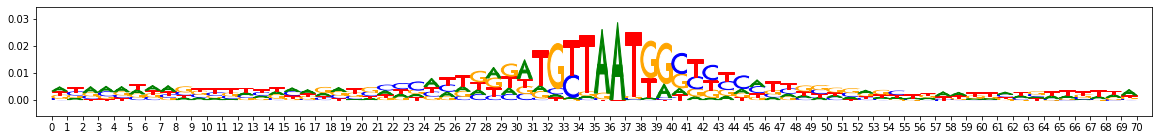

onehot, fwd and rev:


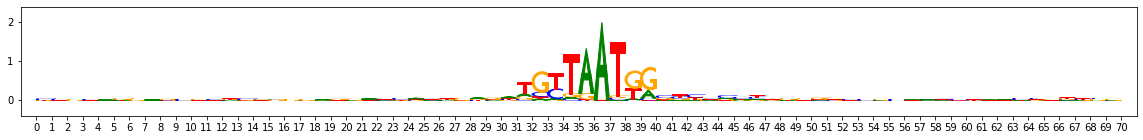

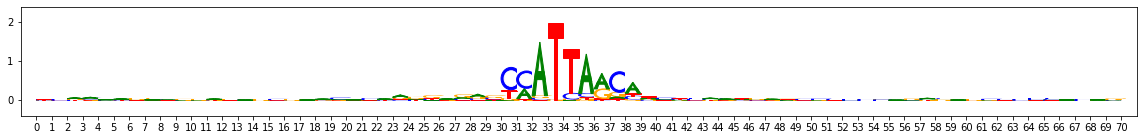

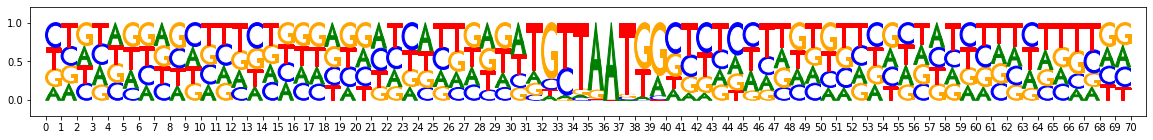

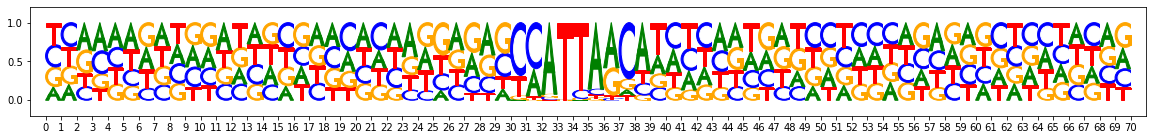

In [8]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background))
        viz_sequence.plot_weights(pattern["sequence"]["fwd"]) 
        viz_sequence.plot_weights(pattern["sequence"]["rev"]) 
        
hdf5_results.close()

### (extra) Visualize the result of using MEME's motifs to initialize the seqlets
This visualizes the intermediate stage where the MEME-derived motifs are used to create an initial set of seqlet clusters. Can be used to get insight into how the MEME-based initialization influenced the TF-MoDISco results

Inspecting meme-based initialization for seqlets in round 0
round 0 MEME-DISco motif number 0
num seqlets mapped to this motif: 222


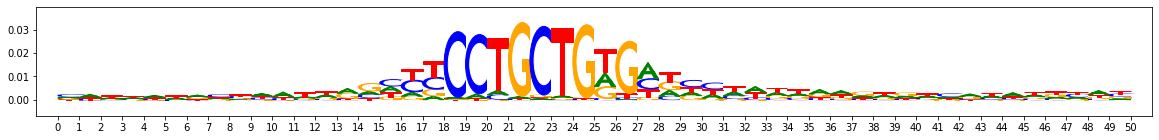

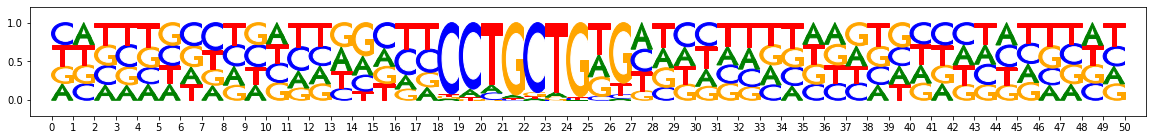

round 0 MEME-DISco motif number 1
num seqlets mapped to this motif: 151


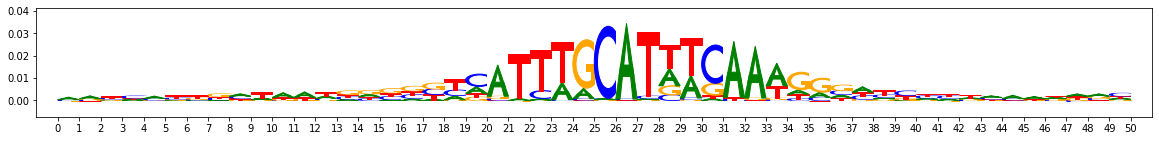

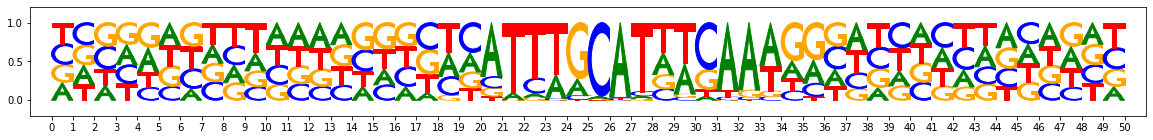

round 0 MEME-DISco motif number 2
num seqlets mapped to this motif: 126


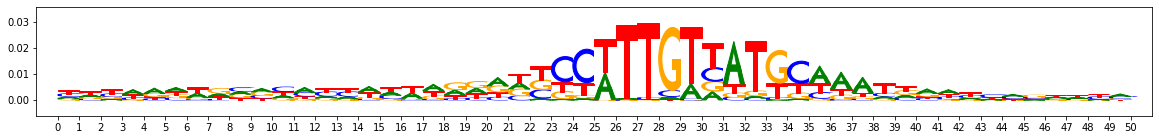

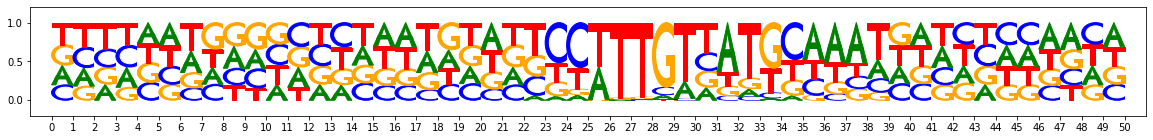

round 0 MEME-DISco motif number 3
num seqlets mapped to this motif: 86


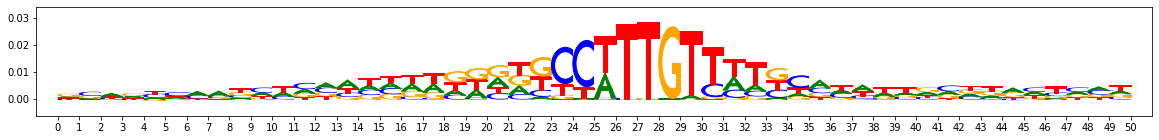

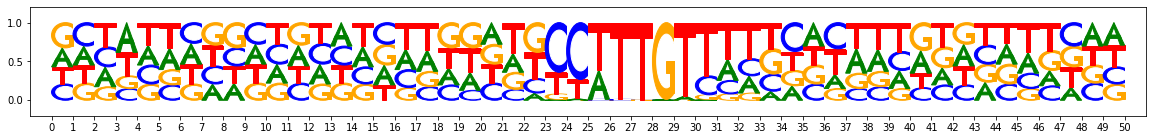

round 0 MEME-DISco motif number 4
num seqlets mapped to this motif: 80


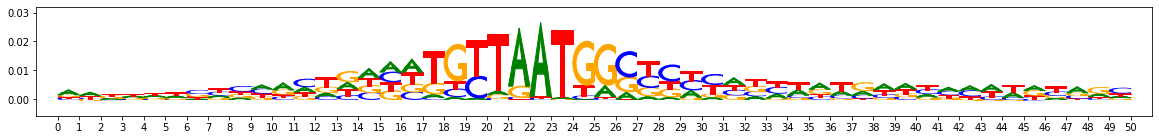

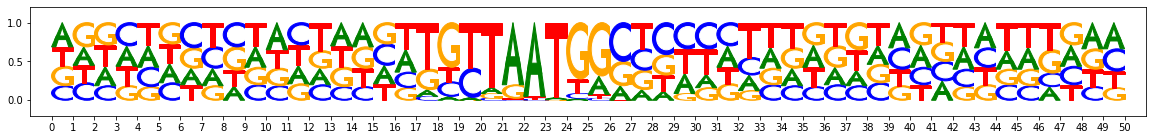

round 0 MEME-DISco motif number 5
num seqlets mapped to this motif: 43


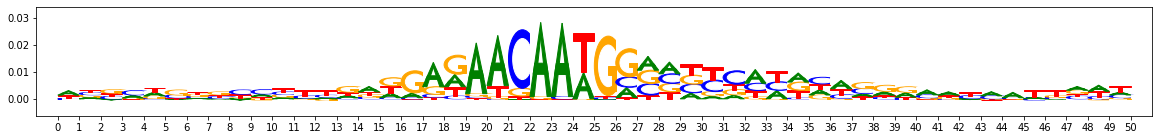

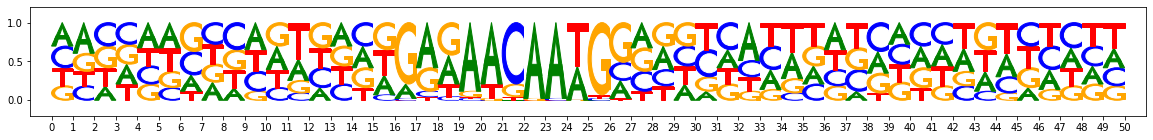

round 0 MEME-DISco motif number 6
num seqlets mapped to this motif: 39


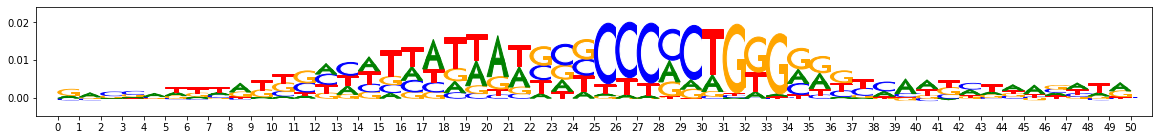

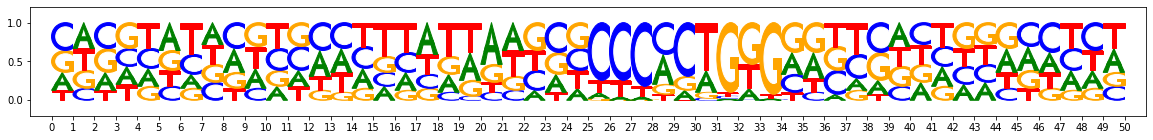

Inspecting meme-based initialization for seqlets in round 1
round 1 MEME-DISco motif number 0
num seqlets mapped to this motif: 222


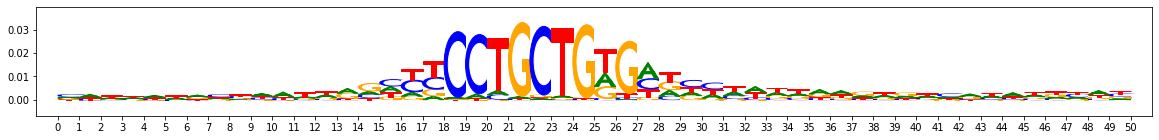

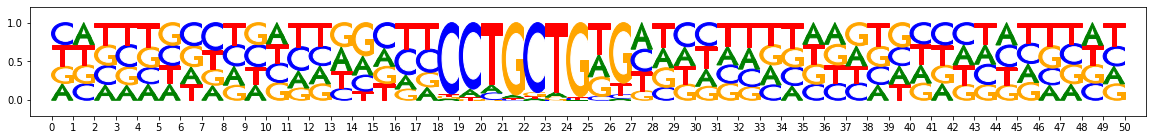

round 1 MEME-DISco motif number 1
num seqlets mapped to this motif: 151


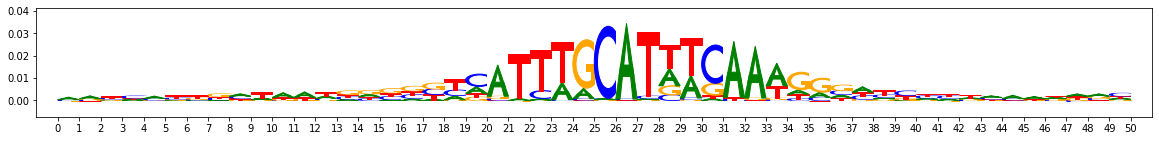

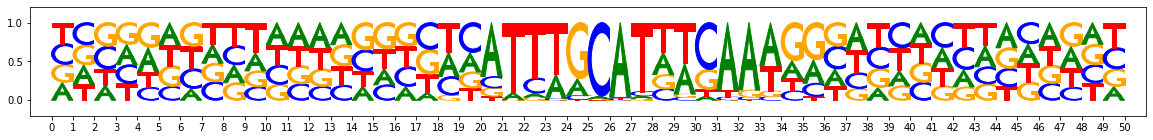

round 1 MEME-DISco motif number 2
num seqlets mapped to this motif: 126


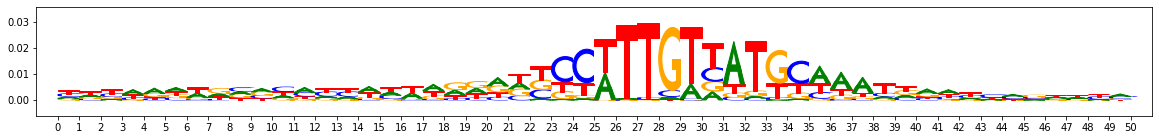

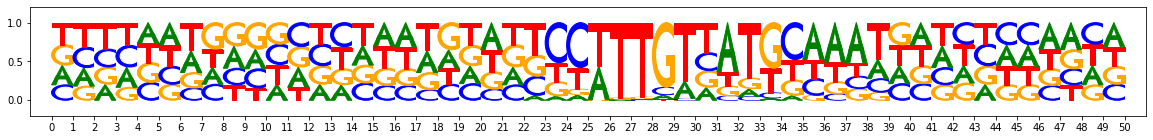

round 1 MEME-DISco motif number 3
num seqlets mapped to this motif: 86


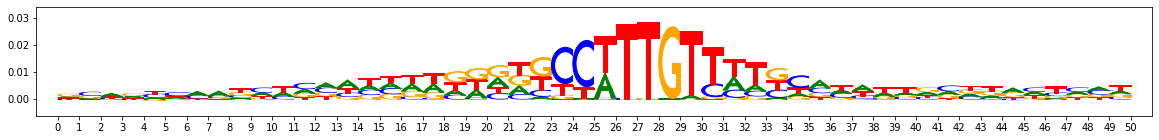

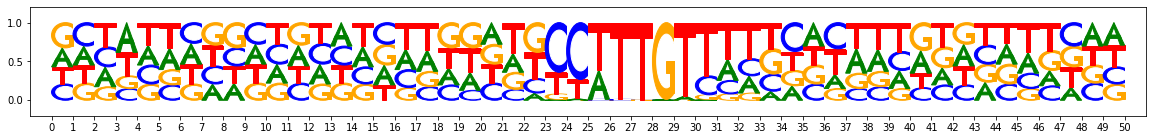

round 1 MEME-DISco motif number 4
num seqlets mapped to this motif: 80


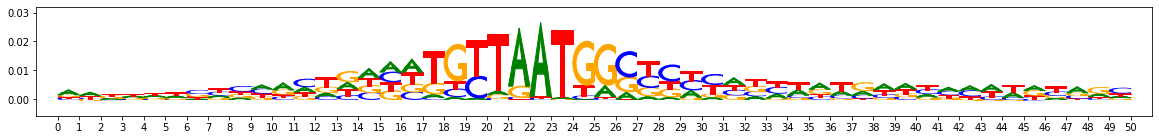

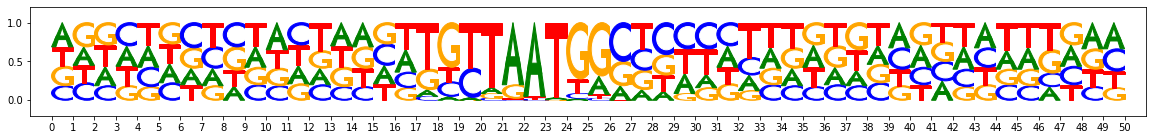

round 1 MEME-DISco motif number 5
num seqlets mapped to this motif: 43


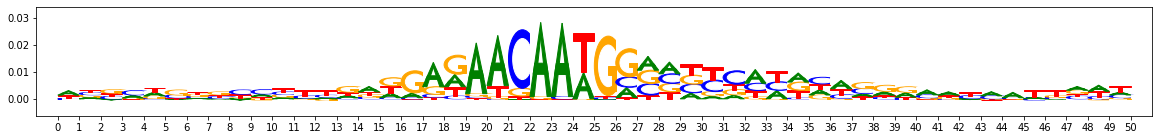

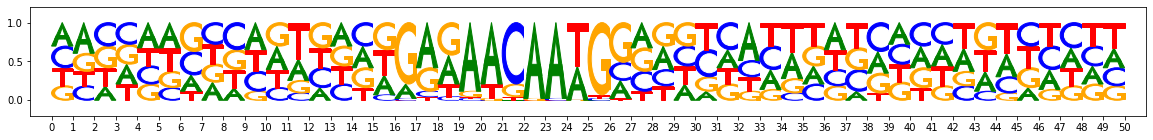

round 1 MEME-DISco motif number 6
num seqlets mapped to this motif: 39


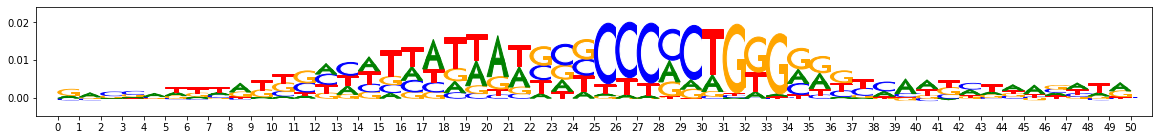

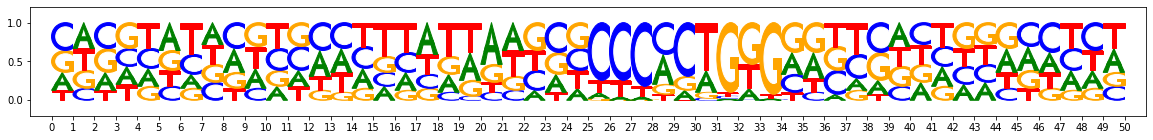

In [12]:
from modisco.visualization import viz_sequence
for round_idx in [0,1]:
    print("Inspecting meme-based initialization for seqlets in round",round_idx)
    meme_discovered_motifs = (tfmodisco_results
        .metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result
        .each_round_initcluster_motifs[0])
    for idx,motif in enumerate(meme_discovered_motifs):
        print("round",round_idx,"MEME-DISco motif number",idx)
        print("num seqlets mapped to this motif:",len(motif.seqlets))
        viz_sequence.plot_weights(motif["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(motif["sequence"].fwd)